
##    **Projet science de donnée**

In [20]:
import numpy as np
import seaborn as sns
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mplc
import plotly.express as px
!pip install geopandas

# 1.La map

In [21]:
data = pd.read_csv("Methane_final.csv", sep=",")
#On supprime les colonnes qui ne sont pas utiles
data=data.drop(columns=["baseYear"])
data=data.drop(columns=["notes"])
data=data.drop(columns=["Unnamed: 0"])
#On supprime les lignes qui ne sont pas utiles
data = data[(data['country'] != 'European Union') & (data['country'] != 'Other EU7 countries')& (data['country'] != 'Other EU17 countries')& (data['country'] != 'World')]
data1 = data[data['segment'] == 'Total']
#data1.to_csv("nouv.csv", index=False) # On enregistre le nouveau fichier nettoyé



<ipython-input-22-5a1e4599356d>:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



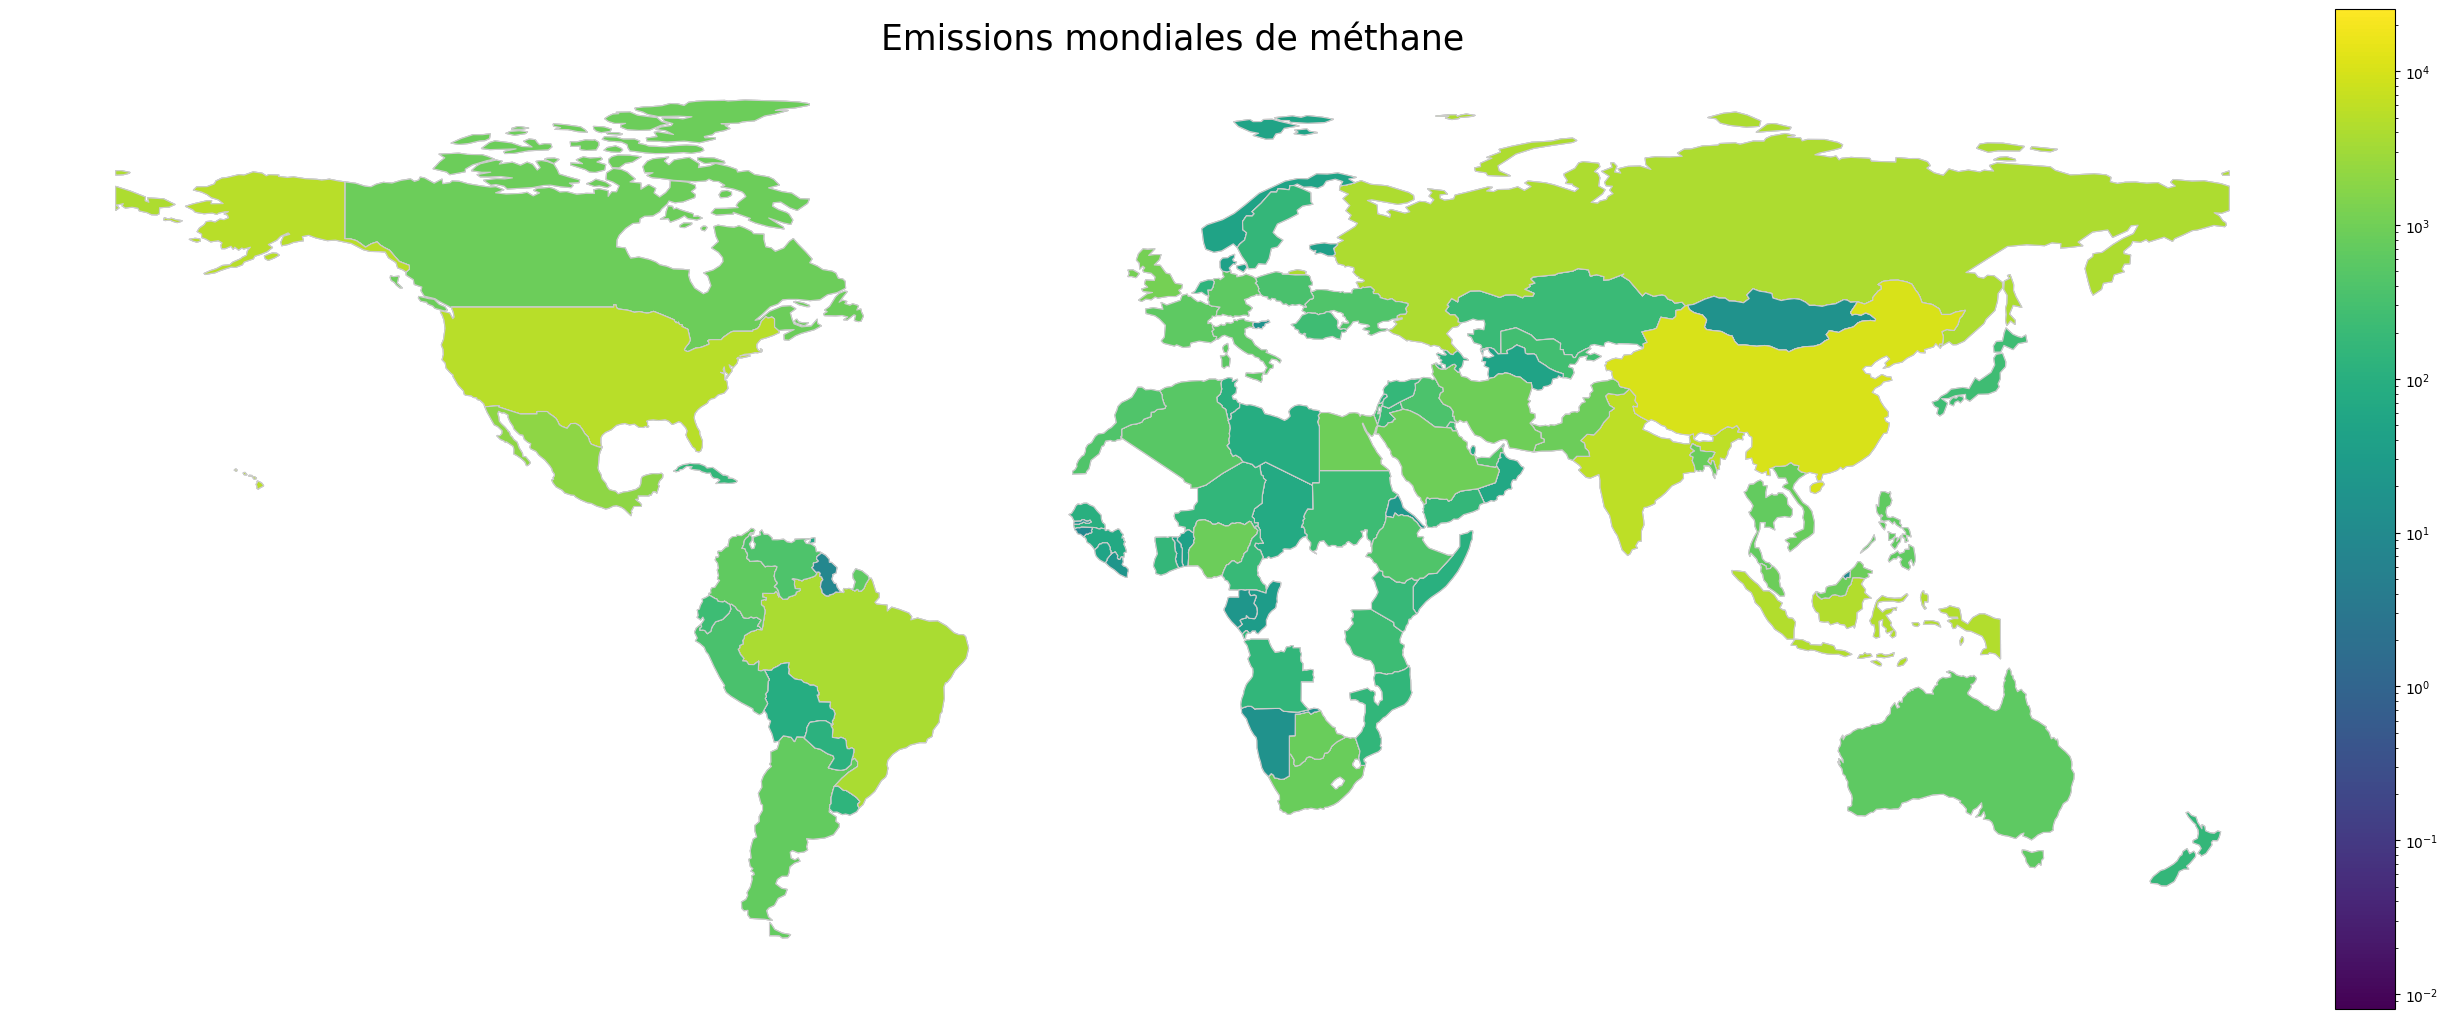

<Figure size 640x480 with 0 Axes>

In [22]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) #On charge un GeoDataFrame appelé 'world', qui contient des informations géographiques sur les pays du monde, à partir de l'ensemble de données 'naturalearth_lowres' fourni avec GeoPandas
#On remplace les noms qui ne correspondent pas entre notre jeu de données et le GeoDataFrame de Geopandas
world['name'] = world['name'].replace('United States of America', 'United States')
world['continent'] = world['continent'].replace('South America', 'Central and South America')
world['continent'] = world['continent'].replace('Asia', 'Asia Pacific')

merged_data = world.merge(data1,  left_on='name', right_on='country')
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['pop_est', 'continent', 'name','iso_a3','gdp_md_est']
# Supprimer les colonnes spécifiées
merged_data = merged_data.drop(colonnes_a_supprimer, axis=1)

# Créer une figure et un axe
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

# Utiliser la méthode plot de geopandas pour créer la carte
merged_data.plot(column='emissions',
                  cmap='viridis',
                  linewidth=0.8, ax=ax, edgecolor='0.8',
                  norm=mplc.LogNorm(vmin=merged_data['emissions'].min(), vmax=merged_data['emissions'].max()),
                  legend=True, cax=plt.axes([0.9, 0.25, 0.02, 0.5]))

ax.axis(False)
ax.set_title('Emissions mondiales de méthane', fontdict={'fontsize': '25', 'fontweight' : '3'})
plt.show()
plt.savefig("carte.png")

# 2.Emission par pays

In [23]:
#On fait la somme des émissions par pays
sum_by_country = data1.groupby(['region', 'country'])['emissions'].sum().reset_index()

# Créer un graphique à barres interactif avec Plotly Express
fig = px.bar(sum_by_country, x='region', y='emissions', color='country',
             labels={'emissions': 'Émissions', 'region': 'Région'},
             height=600, width=1100)

fig.update_layout(title_text='Émissions de méthane par continent et par pays', title_x=0.5)

# Afficher le graphique interactif
fig.show()


# 3.Répartion des émissions par type

In [24]:
# 1.Refaire appel au jeu de données initial
data2= pd.read_csv("Methane_final.csv", sep=",")

# 2. Calculer les émissions totales par pays
emissions_par_pays = data2.groupby('country')['emissions'].sum().reset_index()

# 3. Sélectionner les 4 pays ayant les émissions les plus élevées (en excluant 'World')
pays_principaux = emissions_par_pays[emissions_par_pays['country'] != 'World'].nlargest(4, 'emissions')['country']

# 4. Filtrer les données pour inclure uniquement les 4 pays principaux
donnees_pays_principaux = data2[data2['country'].isin(pays_principaux)]

# 5. Créer une heatmap interactive
fig_heatmap_type_pays_principaux = px.imshow(donnees_pays_principaux.pivot_table(index='type', columns='country', values='emissions', aggfunc='sum'),
                                              labels=dict(x='Country', y='Type', color='Émissions'),
                                              color_continuous_scale='Burgyl',
                                              title='Heatmap des émissions par type pour les 4 pays principaux')

# 6. Afficher le graphique interactif
#fig_heatmap_type_pays_principaux.write_image("heatmap.png") # Permet d'enregistrer l'image sous plotly.express
fig_heatmap_type_pays_principaux.show()

# 4.Répartition des pays principaux par rapport à la raison


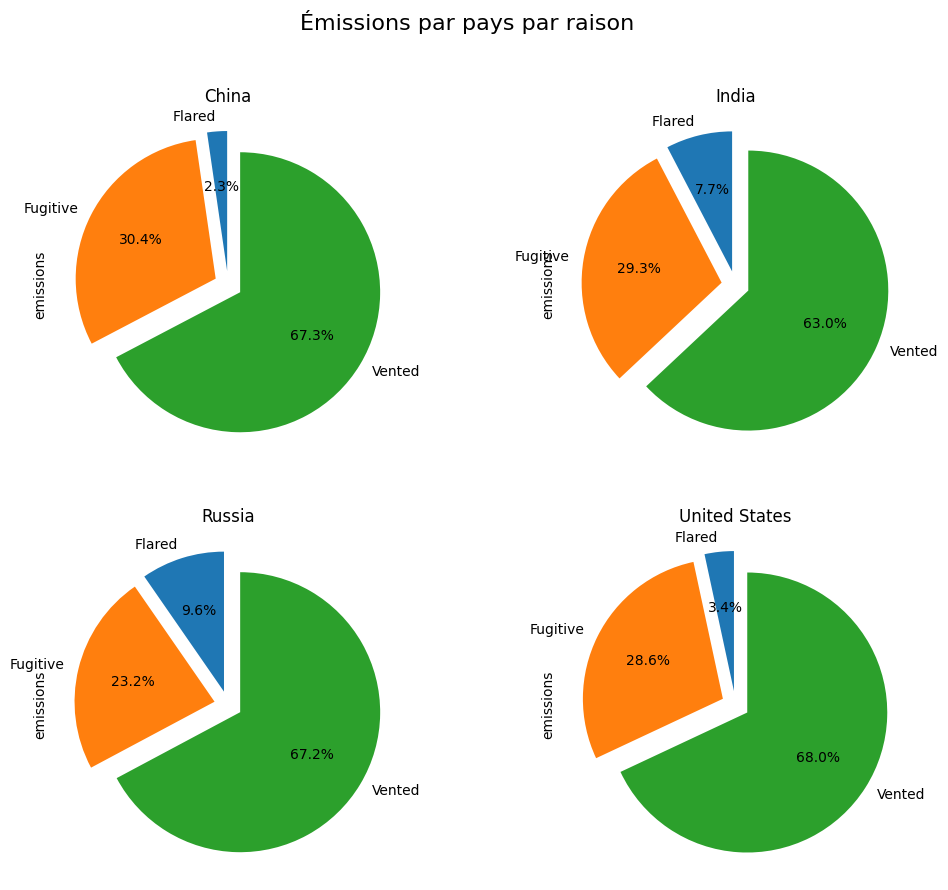

In [25]:
# 1.Filtrer les données pour exclure la raison 'All'
data2_filtered = donnees_pays_principaux[donnees_pays_principaux['reason'] != 'All']

# 2.Créer une figure avec 2 sous-graphiques en disposition 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Émissions par pays par raison', fontsize=16)

# 3.Définir les valeurs d'éclatement pour chaque pays
explode_values = (0.1, 0.1, 0.1, 0.1)  # À ajuster selon vos préférences

# 4.Itérer à travers les pays pour créer les camemberts éclatés
for (country, data), ax, explode_val in zip(data2_filtered.groupby('country'), axes.flatten(), explode_values):
    data.groupby('reason')['emissions'].sum().plot.pie(ax=ax, autopct='%1.1f%%', startangle=90, explode=(explode_val,)*len(data['reason'].unique()))
    ax.set_title(country)

plt.savefig('pie')
plt.show()